# Dependencies

In [65]:
import pandas as pd
import cleantext
import csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Data cleaning and structuring

In [66]:
clean_new_data = False # Set this to False if you just want to load data

### Loading the data

In [67]:
if clean_new_data:
    df = pd.read_csv('data_test.csv')
    print(df['content'].head(5))

### cleaning med clean

In [68]:
if clean_new_data:
    df['content'] = df['content'].apply(lambda x: cleantext.clean(text=x))
    print(df['content'].head(5))

### cleaning med clean_words

In [69]:
if clean_new_data:
    df['content'] = df['content'].apply(lambda x: cleantext.clean_words(
        text=x,
        clean_all=True,
        extra_spaces=True,
        stemming=True,
        stopwords=True,
        stp_lang='english',
    ))

    print(df['content'].head(5))

### Export

In [70]:
if clean_new_data:
    df.to_csv('data_cleaned.csv')

# Categorization and splitting

In [71]:
if clean_new_data:
    temp = [] 
    categories = set()  
    convert = {
        '': "skip", 'conspiracy': '0', 'satire': '0', 'reliable': '1',
        'unreliable': '0', 'junksci': '0', 'unknown': 'skip',
        'political': '1', 'fake': '0', 'hate': '0',
        'clickbait': '1', 'bias': '1', 'rumor': '0'
    }

    fakeCount = 0 
    realCount = 0 

    with open("data_cleaned.csv", "r") as src: 
        reader = csv.reader(src) 
        header = next(reader) 
        
        for row in reader:  
            content = row[4]  # Extract category from the fourth column
            categories.add(content)  # Store the unique category
            
            row[4] = convert[row[4]]  # Convert category using the dictionary
            
            if row[4] == "0":
                fakeCount += 1  # Increment fake count
            elif row[4] == "1":
                realCount += 1  # Increment real count
            
            if row[4] != "skip":  # Skip unwanted categories
                temp.append(row)  # Append valid rows to the list

    # Create a DataFrame from the filtered list, keeping the original column names
    df = pd.DataFrame(temp, columns=header)

    # Save the processed data to a new CSV file without renaming columns
    df.to_csv('data_cleaned_fr.csv', index=False)

    # Print the ratio of fake vs. real news articles and number of articles
    print(f"Number of articles left: {len(temp)}")
    print(f"Reliable articles: {realCount}")
    print(f"Fake articles: {fakeCount}")
    print(f"Ratio of fakes: {fakeCount/(fakeCount+realCount)}")
    print(f"Ratio of reliable: {realCount/(fakeCount+realCount)}")

In [72]:
from tqdm import tqdm
# Set a chunk size (e.g., 1000 rows per chunk, adjust based on file size)
chunk_size = 1000
rows = 903678
chunks = []

# Use tqdm to show progress while iterating over chunks
with tqdm(desc="Loading csv file", total=rows) as pbar:
    for chunk in pd.read_csv("data_cleaned_fr.csv", chunksize=chunk_size):
        chunks.append(chunk)
        pbar.update(chunk_size)

# Combine all chunks into a single DataFrame
df = pd.concat(chunks)

train_data = pd.read_csv("data_cleaned_fr.csv")

Loading csv file: 904000it [00:25, 35527.61it/s]                            


### Splitting

In [73]:
X = train_data['content']
y = train_data['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Vectorization

In [74]:
vectorizer = CountVectorizer(stop_words='english', max_features=10000000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print("Original training class distribution:")
print(y_train.value_counts())

Original training class distribution:
type
1    458980
0    263962
Name: count, dtype: int64


### Over sampling

In [75]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vectorized, y_train)
print("Resampled training class distribution:")
print(pd.Series(y_train_resampled).value_counts())

Resampled training class distribution:
type
1    458980
0    458980
Name: count, dtype: int64


# Training and evaluation

### Model training

In [76]:
classifier = MultinomialNB()
classifier.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

### Evaluation on test

In [77]:
y_pred = classifier.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.88      0.77     65991
           1       0.91      0.77      0.83    114745

    accuracy                           0.81    180736
   macro avg       0.80      0.82      0.80    180736
weighted avg       0.83      0.81      0.81    180736



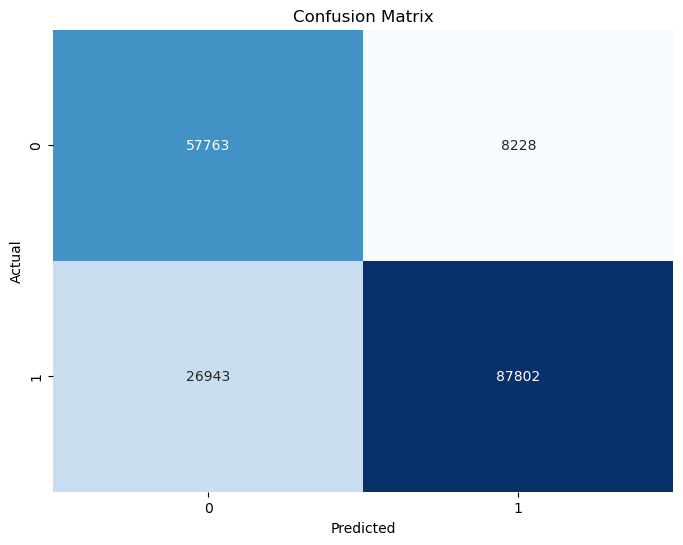

In [78]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()